In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=(BATCH_SIZE)
)

Found 2149 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 1 1 1 1 0 0 0 0 2 1 0 1 1 1 0 0 2 0 1 1 0 0 1 1 1 1 0 1]


In [7]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0]


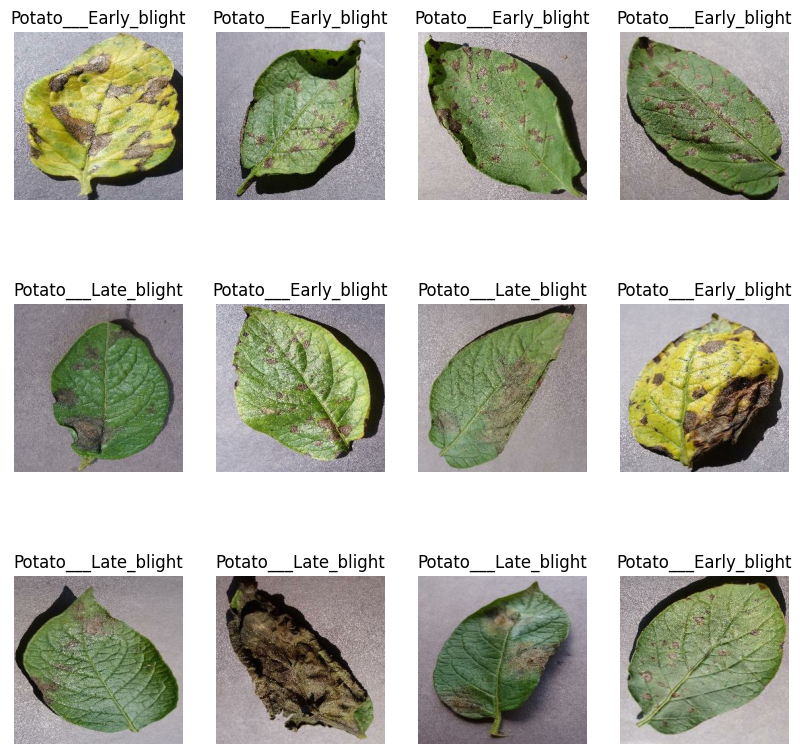

In [8]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [9]:
train_size=0.8 #80% is train and the rest 20% is divided in such a way that 10% is valid and rest is test
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds=dataset.take(54)
test_ds=dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)                
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds
    
#TensorFlow will shuffle the first 1000 elements of the dataset before training


In [15]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)


In [16]:
len(val_ds)

6

In [17]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [20]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)
    

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [23]:
history=model.fit(
    train_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10


54/54 [==============================] - 90s 2s/step - loss: 0.9046 - accuracy: 0.4965 - val_loss: 0.8541 - val_accuracy: 0.4792
Epoch 2/10
54/54 [==============================] - 82s 2s/step - loss: 0.7250 - accuracy: 0.6285 - val_loss: 0.7474 - val_accuracy: 0.6927
Epoch 3/10
54/54 [==============================] - 82s 2s/step - loss: 0.5973 - accuracy: 0.7170 - val_loss: 0.4146 - val_accuracy: 0.8177
Epoch 4/10
54/54 [==============================] - 83s 2s/step - loss: 0.4640 - accuracy: 0.7888 - val_loss: 0.4050 - val_accuracy: 0.8229
Epoch 5/10
54/54 [==============================] - 86s 2s/step - loss: 0.3947 - accuracy: 0.8368 - val_loss: 0.3139 - val_accuracy: 0.8698
Epoch 6/10
54/54 [==============================] - 81s 1s/step - loss: 0.3506 - accuracy: 0.8478 - val_loss: 0.2603 - val_accuracy: 0.9167
Epoch 7/10
54/54 [==============================] - 81s 1s/step - loss: 0.3051 - accuracy: 0.8744 - val_loss: 0.1933 - val_accuracy: 0.9427
Epoch 8/10
54/54 [

In [24]:
scores=model.evaluate(train_ds)

54/54 [==============================] - 17s 307ms/step - loss: 0.2663 - accuracy: 0.8999


In [25]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

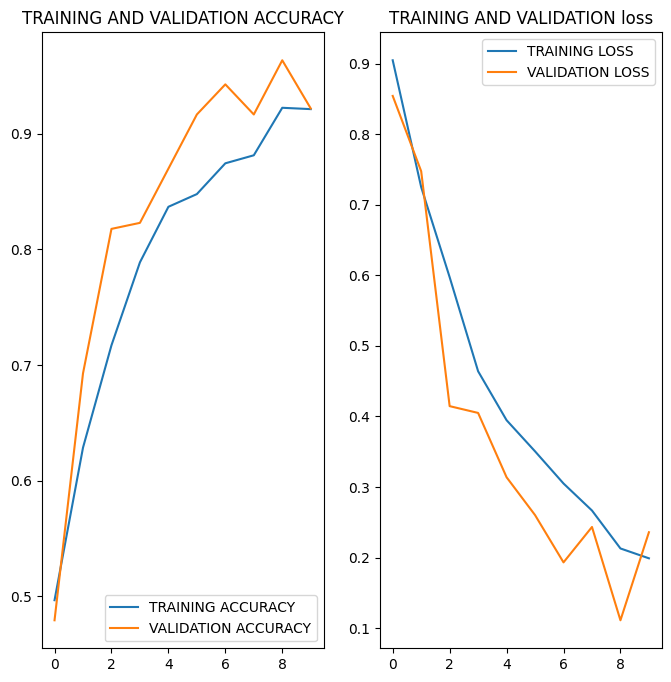

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(10),acc,label='TRAINING ACCURACY')
plt.plot(range(10),val_acc,label='VALIDATION ACCURACY')         
plt.legend(loc='lower right')
plt.title('TRAINING AND VALIDATION ACCURACY')

plt.subplot(1,2,2)
plt.plot(range(10),loss,label='TRAINING LOSS')
plt.plot(range(10),val_loss,label='VALIDATION LOSS')         
plt.legend(loc='upper right')
plt.title('TRAINING AND VALIDATION loss')
plt.show()



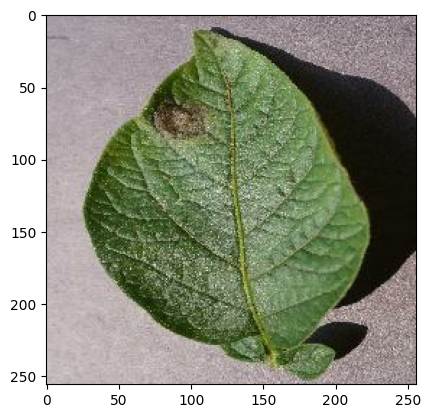

In [34]:
for image_batch,label_batch in dataset.take(1):
   first_img=(image_batch[0].numpy().astype('uint8'))
   first_label=label_batch[0].numpy()
    
   

In [38]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 70ms/step


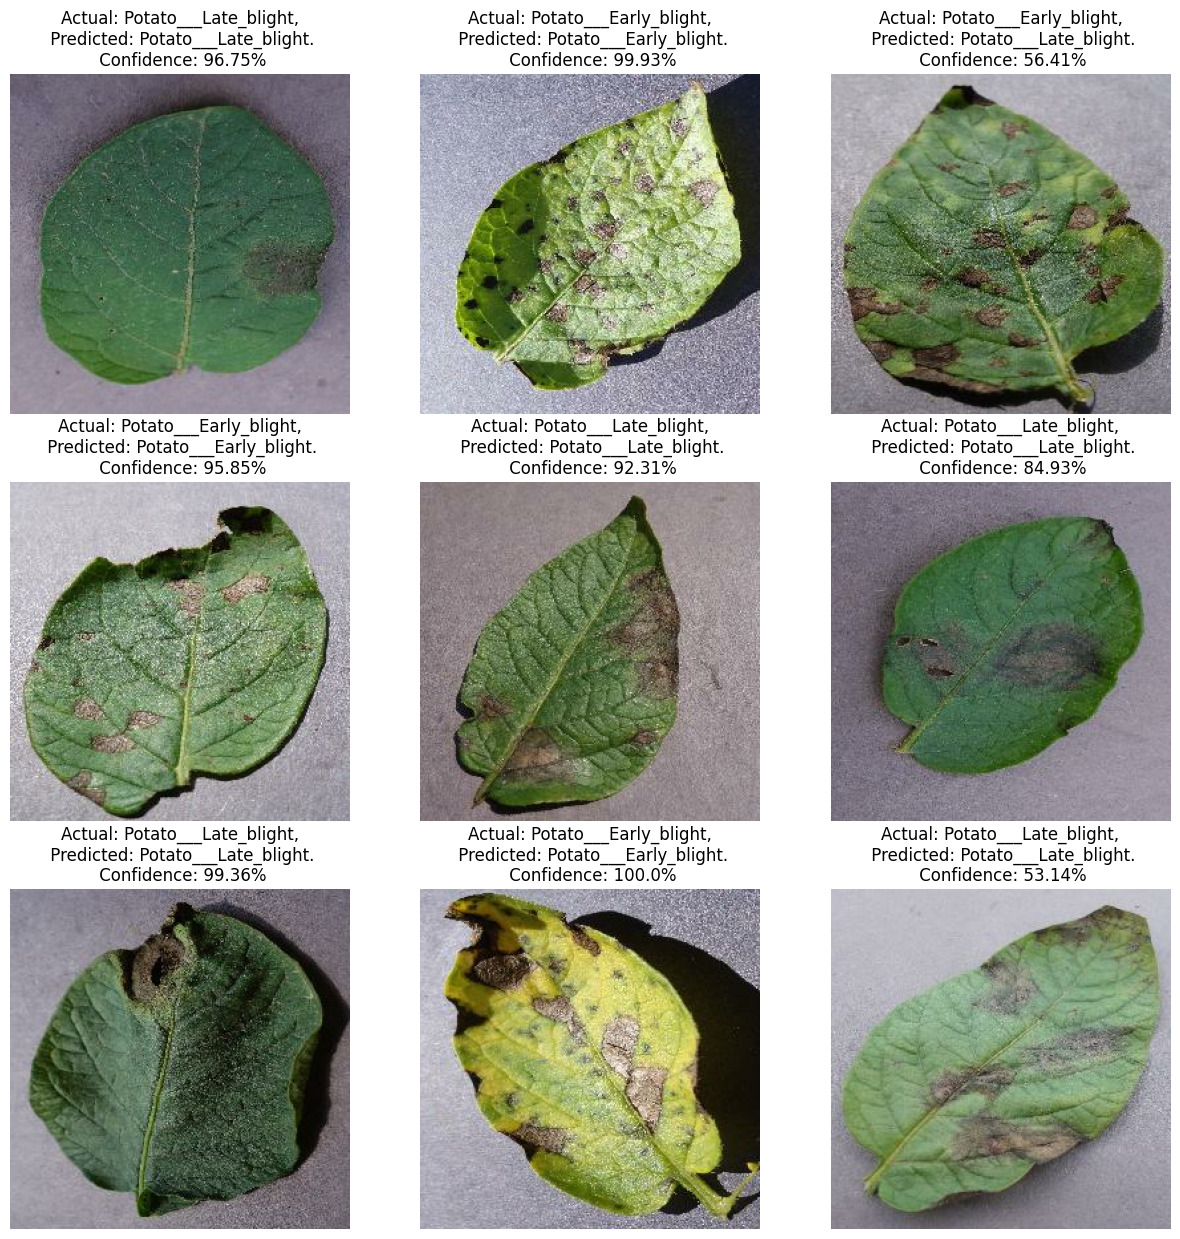

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [46]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
